Contour detection

1. Count Coins

I count 9 coins in this image


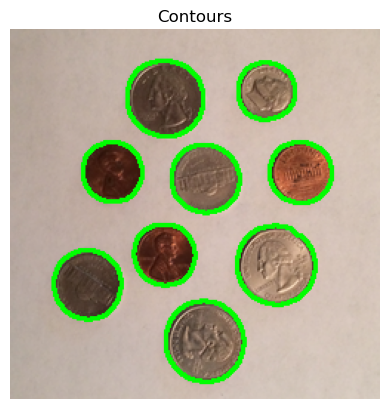

In [3]:
import cv2
import numpy as np
from lib.auto_canny import auto_canny
from lib.helper import draw
import imutils

image = cv2.imread("../data/coins.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edged = auto_canny(blurred)

cnts = imutils.grab_contours(cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE))

print("I count {} coins in this image".format(len(cnts)))
coins = image.copy()
cv2.drawContours(coins, cnts, -1, (0, 255, 0), 2)
draw("Contours", coins)

# for (i, c) in enumerate(cnts):
#     (x, y, w, h) = cv2.boundingRect(c)

#     coin = image[y : y + h, x : x + w]

#     mask = np.zeros(image.shape[:2], dtype="uint8")
#     ((centerX, centerY), radius) = cv2.minEnclosingCircle(c)
#     cv2.circle(mask, (int(centerX), int(centerY)), int(radius), 255, -1)
#     mask = mask[y : y + h, x : x + w]
#     masked = cv2.bitwise_and(coin, coin, mask)
#     draw("Coins #{}".format(i + 1), masked)



2. Apply WaterShed Algorithm on Touching or Overlaping Objects

[INFO] 2 unique contours found
[INFO] 9 unique segments found


/tmp/ipykernel_60856/1001775074.py:42: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20,


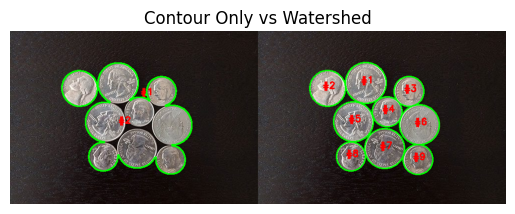

In [12]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from lib.helper import draw
import imutils
import cv2

# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread("../data/watershed_coins_01.jpg")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
# draw("Input", shifted)

# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# draw("Thresh", thresh)

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

# loop over the contours
coins = image.copy()
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	cv2.putText(coins, "#{}".format(i + 1), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(coins, [c], -1, (0, 255, 0), 2)

# draw("image", coins)

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue

	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

draw("Contour Only vs Watershed", np.hstack([coins, image]))

3. Detect Barcode in Image

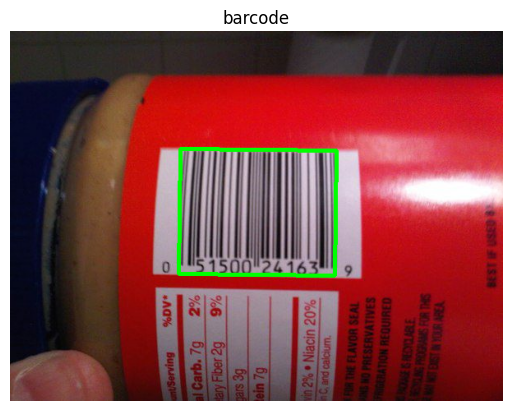

In [4]:
import numpy as np
import imutils
import cv2
from lib import helper

image = cv2.imread("../data/barcode_01.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction
ddepth = cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

# blur and threshold the image
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)


# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations = 4)

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.intp(box)

# draw a bounding box arounded the detected barcode and display the
# image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
helper.draw("barcode", image, True)


4. Mobile Document Scanner

STEP 1: Edge Detection


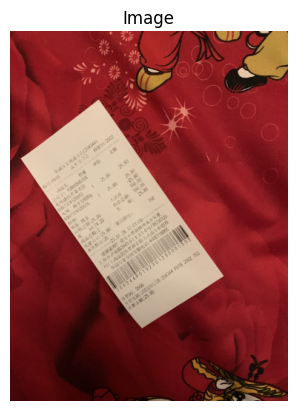

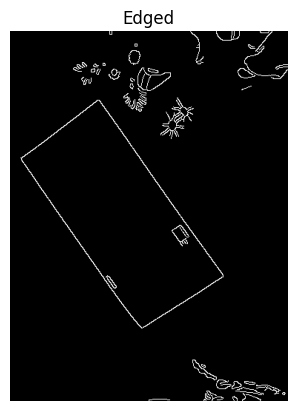

STEP 2: Find contours of paper


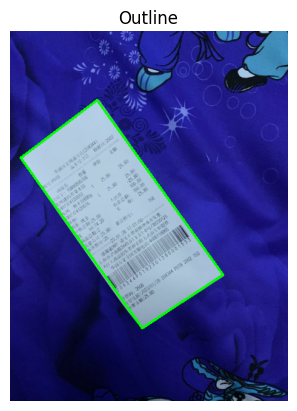

STEP 3: Apply perspective transform


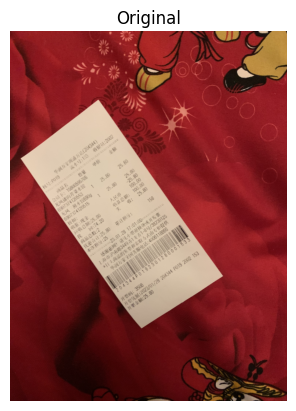

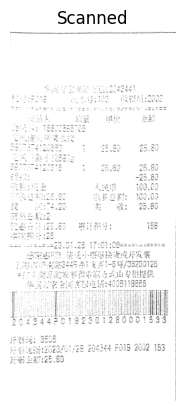

In [1]:
from lib.transform import four_point_transform
from lib.helper import draw
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("../data/receipt.jpeg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
draw("Image", image, True)
draw("Edged", edged, True)
cv2.destroyAllWindows()

# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
draw("Outline", image)
cv2.destroyAllWindows()

# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

print("STEP 3: Apply perspective transform")
draw("Original", imutils.resize(orig, height = 650), True)
draw("Scanned", imutils.resize(warped, height = 650), True)
